# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Introduction to Data Science

## Lab 5:  Anatomy of a Neural Network, NNs /w Keras, & NN Interpretation

**Harvard University**<br/>
**Spring 2024**<br/>
**Instructors**: Pavlos Protopapas & Alex Young<br/>
<br/>

### Table of Contents
- Part 1: Anatomy of a NN
    - affine transformation /w weights and biases
    - activation function
    - hidden layers
    - output activation
    - Multilayer perceptron (MLP) from scratch
    
- Part 2: Building an NN /w Keras
    - Defining a model with Keras `Sequential`
    - Compiling
    - Fitting
    - Inspecting Training History
    - Prediction & Evaluation
    
- Part 3: Further NN Adventures
    - Multi-class Classification Example (Tabular Data)

- Appendix: Interpreting Our Black Box NN
  * Proxy Model
  * Varying a Single Predictor
  * Bagging Review

In [8]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error

# New!
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

## Part 1

<div class='exercise'> <b>Anatomy of a Neural Network</div>    

To learn about the components of a neural network, we'll attempt to model the following data as a binary classification problem.

In [9]:
# show students loading x and y
df = pd.read_csv('data/toydata.csv')
x = df.x.values
y = df.y.values
df.head()

,x,y
0,1.454849,0
1,-0.491639,1
2,0.230769,1
3,-1.575251,0
4,1.695652,0


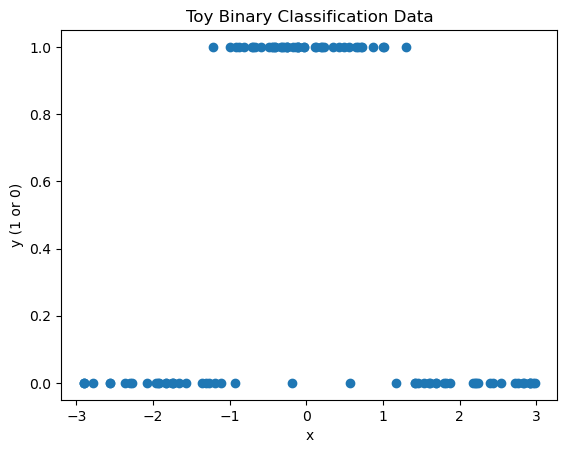

In [10]:
plt.scatter(x, y)
plt.xlabel('x')
plt.ylabel('y (1 or 0)')
plt.title("Toy Binary Classification Data");

Our modeling assumptions are:

$Y \sim Bern(p)$

and

$p = f(x)$

That is, the probability that $Y=1$ is a function of $x$

<div class='exercise'> <b>Neural Networks as a Composition of Functions</div>    

A neural network is a composition of many simple functions. In this example our basic building block with be the **rectified linear unit**, or **ReLU**.

In [11]:
def relu(z: float) -> float :
    return  np.maximum(0, z)
# or 
# relu = lambda z: np.maximum(0, z)

In [12]:
# create an input vector
x_lin = np.linspace(-3,3,300)

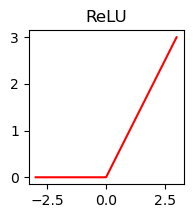

In [13]:
plt.figure(figsize=(2,2))
plt.plot(x_lin, relu(x_lin), c='r')
plt.title('ReLU');

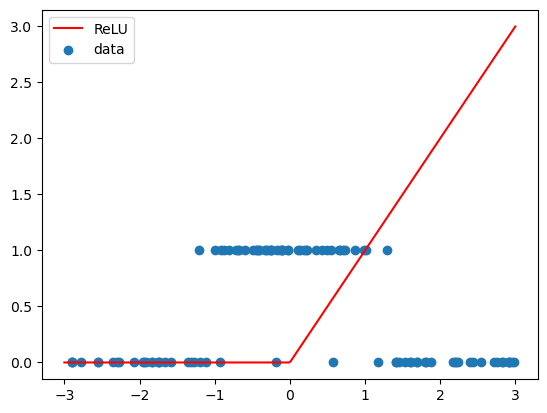

In [14]:
plt.plot(x_lin, relu(x_lin), c='r', label='ReLU')
plt.scatter(x, y, label='data')
plt.legend();

<div class='exercise'> <b>Affine Transformation: weights & biases</div>    

To better fit the data, we coud try scaling and shifting the inputs to relu.

We call the scaling factor the **weight**, $w$, and the amount of the shift the **bias**, $b$.

The scaling and shifting our input is called an **affine transformation**. We refer to the output of the affine transformation as $z$.

**Q:** What is the difference between an *affine transformation* and a *linear transformation*?

<div class='exercise'> <b>Activation Function</div>    

Applying the non-linear function (relu) to the affine transformation is called **activation**.

Relu is our **activation function**! We often refer to the output of the activation as $h$.

<div class='exercise'> <b>One Loney Neuron</div>    

The affine transformation combined with the activation makes up a single **neuron** (sometimes called a 'unit').

<img src='img/nn1.png' width=400>


*(Note: these diagrams show a sigmoid as the activation. We are using ReLU)*

- Try shifting to the left by 2
- Try reversing the direction and shifting to the *right* by 2

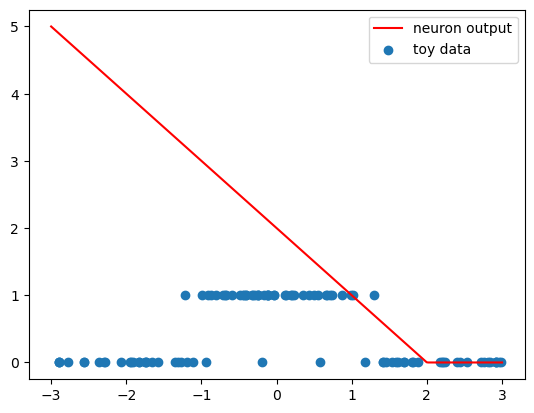

In [15]:
w = -1
b = 2
z = w*x_lin + b
h = relu(z)
plt.plot(x_lin, h, c='r', label='neuron output')
plt.scatter(x, y, label='toy data')
plt.legend();

<div class='exercise'> <b>Multiple Layers: hidden & output</div>    

We saw that we could make two different neurons, each of which fits only *half* of the data well. Can we *combine* them in some way to get better predictions??

Let's try adding them.

<img src='img/nn2.png' width=500>

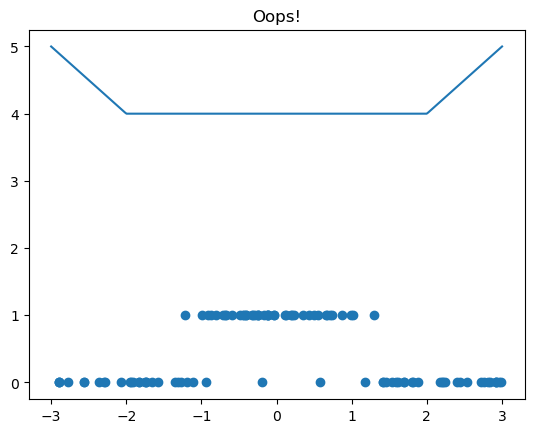

In [21]:
w1, b1 = -1, 2# ?
w2, b2 = 1, 2# ?
z1 = w1*x_lin + b1
z2 = w2*x_lin + b2
h1 = relu(z1)
h2 = relu(z2)
plt.plot(x_lin, h1+h2)
plt.scatter(x, y)
plt.title("Oops!");

We're obviously not there yet! It looks like we might want to scale and shift $h_1$ & $h_2$ again.

In fact, $h_1$ and $h_2$ will become inputs to a *new* **layer**, the **output layer**. Our output layer will gave a single neruon because our output is a scalar (the probability of $y=1$).

$h_1$ & $h_2$ are neurons in the **hidden layer**. "Hidden" in the sense that we don't actually observe their outputs; they are passed to the next layer as input. A NN can have *many* hidden layers.

The output neuron is the **output layer** (you can also have multiple output layers, but that is a story for another time!)

The output neuron will need a weight & bias for *both* $h1$ and $h2$.

It will also need its own **output activation function**!

<div class='exercise'> <b>Output Activation</div>    

<img src='img/nn3.png' width=600>

Because we are modeling a binary $y$, we want our output to represent the probability of $y=1$. This means that the output must be in [0,1].

But relu is $[0, \infty]$! We need a different activation function for our output neuron.

What function do you know that has output bounded in [0,1]?

In [22]:
def sigmoid(z: float) -> float : 
    return 1/(1 + np.exp(-z)) 

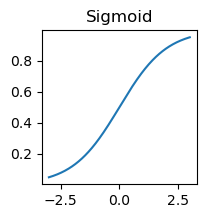

In [23]:
# plot sigmoid activation
plt.figure(figsize=(2,2))
plt.plot(x_lin, sigmoid(x_lin))
plt.title('Sigmoid');

<div class='exercise'> <b>Constructing our First MLP (Multilayer Perceptron aka Neural Network)</div>    

Now all we need to do is define weights & bias for all three neurons.
**Remember!** The output neuron needs a weight for *each* of its inputs ($h_1$ & $h_2$)

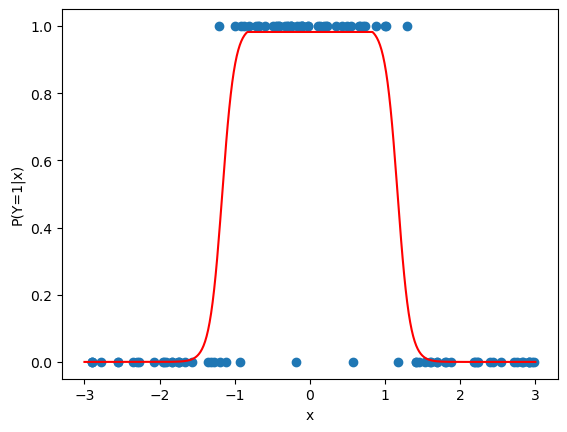

In [29]:
# hidden layer
w1, b1 = 6, -5
w2, b2 = -6, -5
z1 = w1*x_lin + b1
z2 = w2*x_lin + b2
h1 = relu(z1)
h2 = relu(z2)
# output layer
w31, w32, b3 = -2,-2,4
z3 = w31*h1 + w32*h2 + b3
output = sigmoid(z3)

# plot predictions
plt.plot(x_lin, output, c='r')
plt.scatter(x, y)
plt.xlabel('x')
plt.ylabel('P(Y=1|x)');

Now let us calculate the accuracy of our predictions! 

Bear in mind, that what we got so far is not the prediction yet, but rather just probabilities. If a probability is above 0.5, then our prediction is 1, else our prediction is 0. 

🏋️ **Let us complete the code below.**


In [31]:
# hidden layer
z1 = w1*x + b1
z2 = w2*x + b2
h1 = relu(z1)
h2 = relu(z2)
# output layer
z3 = w31*h1 + w32*h2 + b3
p = sigmoid(z3)

# output values > 0 are predicted to be 1, otherwise 0
# your code here
y_hat  = (p > 0.5).astype(int)
# calculate the accurracies
acc = sum((y_hat == y)/len(y))
acc

0.9400000000000006

## Part 2

<div class='exercise'> <b>Tensorflow & Keras</div>    

**Keras, Sequential:**

https://keras.io/models/sequential/


There are many powerful deep learning packages to work with neural networks like **TensorFlow** and **PyTorch**. These packages provide both the forward and back propagations, and many other other functionalities. The forward pass is used to make   predictions while the backward (back propagation)  is used to  train (optimize) a network. 'Training' refers to find the optimal parameters for a specific task. We'll talk more about optimization and back propogation next week!

Keras is a high-level API that allows us to work with abstraction at the level of "layers" rather than the low-level representations of neural networks that you work with in TensorFlow (computational graphs).

Here, we use Keras's `Sequential` Model to create a neural network for our toy binary classification problem.\
We'll use the same 'architecture' as above:
- 1 hidden layer /w 2 neurons using relu activation
- an ouput layer /w 1 neuron using sigmoid activation

In [62]:
# import modules containing Keras classes we'll use today
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

In [69]:
keras.utils.set_random_seed(209)
# define a sequential model called 'first_model'
model = models.Sequential(name='first_model')
# add a hidden layer with 2 neurons and relu activations
# not we specify the input shape is 1D (scalar)
model.add(layers.Dense(2,
                       activation='relu',
                       input_shape=(1,)))
# add an output layer containing a single neuron with sigmoid activation
model.add(layers.Dense(1,
                       activation='sigmoid'))
# display model summary
model.summary()

Model: "first_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 2)                 4         
                                                                 
 dense_13 (Dense)            (None, 1)                 3         
                                                                 
Total params: 7 (28.00 Byte)
Trainable params: 7 (28.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


<div class='exercise'> <b>Compiling the NN</div>

    


`Model.compile(optimizer, loss, metrics, **kwargs)`

https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile

`optimizer` - defines how the weights are updated (we'll use SGD; more on this next lecture!)\
`loss` - what the model is trying to minimize\
`metric` - list of metrics to report during training process

`compile` is used to configure a NN model be for it can be fit. We aren't ready to fit *just* yet, but we are compiling here because doing so reinitilizes the model weights. We are going to manually set our weights before training so we need to to the compilation first.

**Q:** Why do I want metrics if I already have a loss?

In [70]:
model.compile(loss='binary_crossentropy',
              metrics=['accuracy'],
              optimizer=optimizers.SGD(learning_rate=1e-1)
)

<div class='exercise'> <b>Fitting the NN</div>    

`Model.fit(x=None, y=None, batch_size=None, epochs=1, verbose="auto", validation_split=0.0, validation_data=None, shuffle=True, **kwargs)`

https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit

`batch_size` - number of observations overwhich the loss is calculated before each weight update (more on this next lecture)\
`epochs` - number of times the complete dataset is seen in the fitting process\
`verbose` - you can silence the training output by setting this to `0`\
`validation_split` - splits off a portion of the `x` and `y` training data to be used as validation (see warning below)\
`validation_data` - tuple designating a seperate `x_val` and `y_val` dataset\
`shuffle` - whether to shuffle the training data before each epoch

In [71]:
# We'll use 20% of the data as validation and train for 500 epochs
model.fit(x=x,
          y=y,
          validation_split=.2,
          epochs=500,
          verbose=1);

Epoch 1/500
3/3 [==============================] - 1s 72ms/step - loss: 0.6267 - accuracy: 0.5000 - val_loss: 0.6044 - val_accuracy: 0.6000
Epoch 2/500
3/3 [==============================] - 0s 10ms/step - loss: 0.6138 - accuracy: 0.5625 - val_loss: 0.5942 - val_accuracy: 0.6000
Epoch 3/500
3/3 [==============================] - 0s 11ms/step - loss: 0.6066 - accuracy: 0.5500 - val_loss: 0.5880 - val_accuracy: 0.5000
Epoch 4/500
3/3 [==============================] - 0s 11ms/step - loss: 0.6031 - accuracy: 0.5750 - val_loss: 0.5862 - val_accuracy: 0.5000
Epoch 5/500
3/3 [==============================] - 0s 12ms/step - loss: 0.5967 - accuracy: 0.5750 - val_loss: 0.5803 - val_accuracy: 0.5500
Epoch 6/500
3/3 [==============================] - 0s 11ms/step - loss: 0.5927 - accuracy: 0.6000 - val_loss: 0.5757 - val_accuracy: 0.6000
Epoch 7/500
3/3 [==============================] - 0s 12ms/step - loss: 0.5865 - accuracy: 0.6000 - val_loss: 0.5725 - val_accuracy: 0.6000
Epoch 8/500
3/3 [===

<div class='exercise'> <b>Plot Training History</div>

A fitted model's `history.history` attribute is a dictionary which contains information from each training epoch (no, I don't know the rationale behind the double name). Use it to plot the loss across epochs. Don't forget those axis labels! We need to distinguish train from validation.

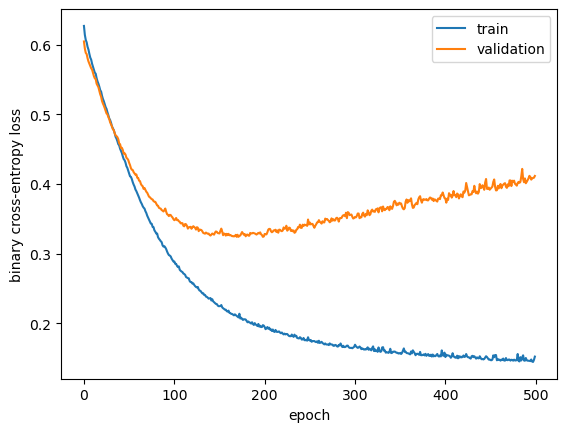

In [72]:
plt.plot(model.history.history['loss'], label='train')
plt.plot(model.history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('binary cross-entropy loss')
plt.legend();

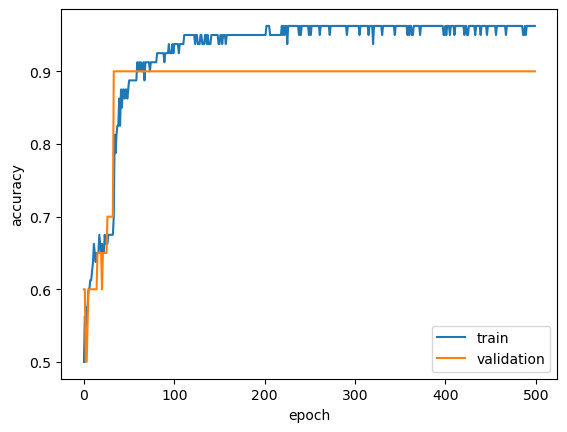

In [73]:
plt.plot(model.history.history['accuracy'], label='train')
plt.plot(model.history.history['val_accuracy'], label='validation')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend();

<div class='exercise'> <b>Predict & Plot</div>

We use the model's `predict` method on a linspace, `x_lin`, which we previously constructed to span the range of the dataset's $x$ values. We save the resulting predictions in `y_hat`

10/10 [==============================] - 0s 1ms/step


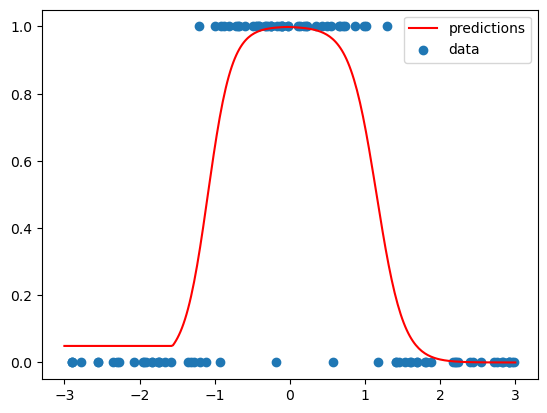

In [75]:
y_hat = model.predict(x_lin)
plt.plot(x_lin, y_hat, c='r', label='predictions')
plt.scatter(x, y, label='data')
plt.legend();

In [76]:
model.evaluate(x, y)

4/4 [==============================] - 0s 2ms/step - loss: 0.1980 - accuracy: 0.9500


[0.197972372174263, 0.949999988079071]

<div class='exercise'> <b>Save & Reload model</div>

Fitting non-trivial neural networks can take a long time. It is important to know how to save and reload your Keras models.

In [77]:
# save model
model.save('first_keras_model')
# reload saved model into new variable
model_reload = models.load_model("first_keras_model")
# display summary
model_reload.summary()

INFO:tensorflow:Assets written to: first_keras_model/assets


INFO:tensorflow:Assets written to: first_keras_model/assets


Model: "first_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 2)                 4         
                                                                 
 dense_13 (Dense)            (None, 1)                 3         
                                                                 
Total params: 7 (28.00 Byte)
Trainable params: 7 (28.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


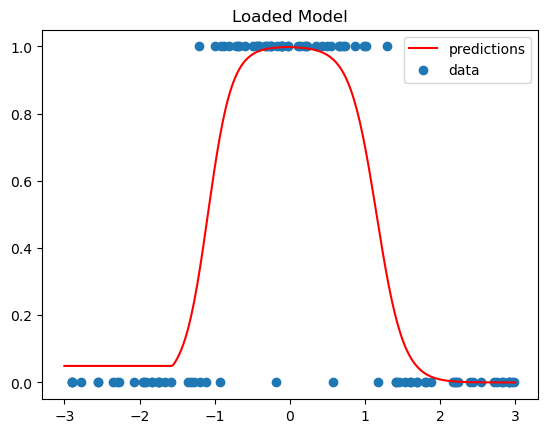

In [78]:
y_hat = model_reload.predict(x_lin, verbose=0)
plt.plot(x_lin, y_hat, c='r', label='predictions')
plt.scatter(x, y, label='data')
plt.title("Loaded Model")
plt.legend();

<div class='exercise'> <b>An Ugly Function (Regression Example)</div>
    

Now let's try a regression task where the response variable we are modeling can take on any real value.

In [79]:
def ugly_function(x):
    if x < 0:
        return np.exp(-(x**2))/2 + 1 + np.exp(-((10*x)**2))
    else:
        return np.exp(-(x**2)) + np.exp(-((10*x)**2))

How do you feel about the prospect of manually setting the weights to approximate this beauty?

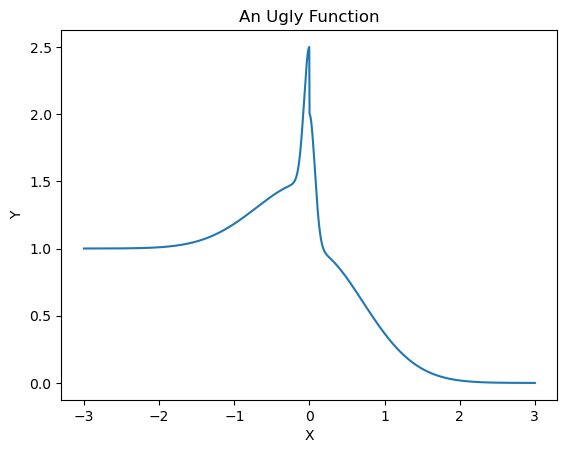

In [80]:
# Generate data
x_ugly = np.linspace(-3,3,1500) # create x-values for input
y_ugly = np.array(list(map(ugly_function, x_ugly)))

# Plot data
plt.plot(x_ugly, y_ugly);
plt.title('An Ugly Function')
plt.xlabel('X')
plt.ylabel('Y');

<div class="alert alert-success">
    <strong>🏋🏻‍♂️ TEAM ACTIVITY:</strong> We're Gonna Need a Bigger Model...</div>  

Construct an NN to approximate the ugly function with Kera's `Sequential` Model.

**Build & Print Model Summary**

You can play with the number of hidden (`Dense`) layers and the number of neurons in each.

**Q:** what should the output activation function be for a regression task?

In [81]:
# your code here
ugly_model = models.Sequential(layers=[layers.Dense(64, activation='relu', input_shape=(1,)),
                                       layers.Dense(32, activation='relu'),
                                       layers.Dense(16, activation='relu'),
                                       layers.Dense(8, activation='relu'),
                                       layers.Dense(1, activation='linear')],
                              name='ugly_model')

ugly_model.summary()

Model: "ugly_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 64)                128       
                                                                 
 dense_15 (Dense)            (None, 32)                2080      
                                                                 
 dense_16 (Dense)            (None, 16)                528       
                                                                 
 dense_17 (Dense)            (None, 8)                 136       
                                                                 
 dense_18 (Dense)            (None, 1)                 9         
                                                                 
Total params: 2881 (11.25 KB)
Trainable params: 2881 (11.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**Compile**\
Use the `SGD` optimizer and `'mse'` as your loss.\
You can expermiment with `SGD`'s `learning_rate`.

In [82]:
ugly_model.compile(loss='mse',
               optimizer=optimizers.SGD(learning_rate=0.1))

**Fit**\
Fit `ugly_model` on `x_ugly` and `y_ugly`.\
You can experiment with the number of `epochs`.

In [83]:
ugly_model.fit(x_ugly, y_ugly, epochs=100, verbose=0)

**Plot Training History**

Plot the model's training history. Don't forget your axis labels!\
**Hint:** Remember, `fit` returns a `history` object which itself has a `history` dictionary attribute. Because this (2nd object) is a dictionary, you can always use its `keys`method if you don't know what's in it. You can also access the history from the model itself. Ex: `ugly_model.history.history`

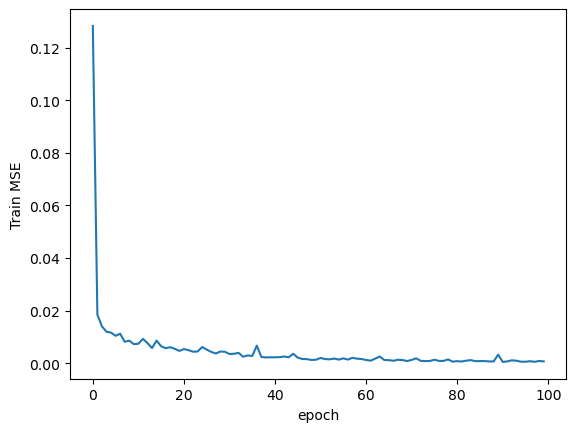

In [84]:
# Plot History
# your code here
plt.plot(ugly_model.history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('Train MSE');

**Get Predictions**\
Similar to `sklearn` models, `keras` models have a `predict` method. Use your model's `predict` method to predict on `x_ugly` and store the results in a variable called `y_hat_ugly`.

In [85]:
# Predict
# your code here
y_hat_ugly = ugly_model.predict(x_ugly)

47/47 [==============================] - 0s 1ms/step


**Plot Predictions**\
Run the cell below to compare your model's predictions to the true (ugly) function. Still not quite right? Try tweaking some of the hyperparameters above and re-run the cells in this section to see if you can improve.

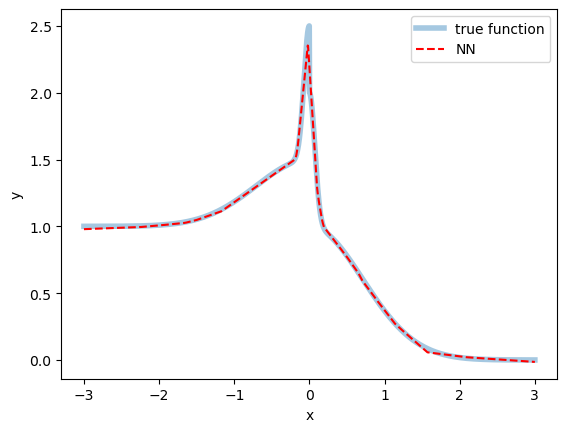

In [86]:
# Plot predictions
plt.plot(x_ugly, y_ugly, alpha=0.4, lw=4, label='true function')
plt.plot(x_ugly, y_hat_ugly, label='NN', ls='--', c='r')

plt.xlabel('x')
plt.ylabel('y')
plt.legend();

Not bad!

**End of team activity**

## Part 3

<div class='exercise'> <b>Multi-class Classification with Keras</div>


So far we've only used our new Keras powers for toy regression and binary classification problems. Now we'll try classification with 3 classes!

This example will use `seaborn`'s penguins dataset (last time, I promise!)

We'll build a model to identify a penguin's species from its other features. In the process we'll dust off our Python skills with a *very* quick run through of a basic model building workflow.

In [87]:
# Bring on the penguins!
penguins = pd.read_csv('data/penguins.csv')
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


We have 3 species of penguins living across 3 different islands. There are measurements of bill length, bill depth, flipper length, and body mass. We also have categorcial variable for each penguin's sex giving us a total of 7 features.

Here's a plot that tries to show too much at once. But you can ignore the marker shapes and sizes. The bill and flipper length alone ($x$ and $y$ axes) seem too already provide a fair amount of information about the species (color).

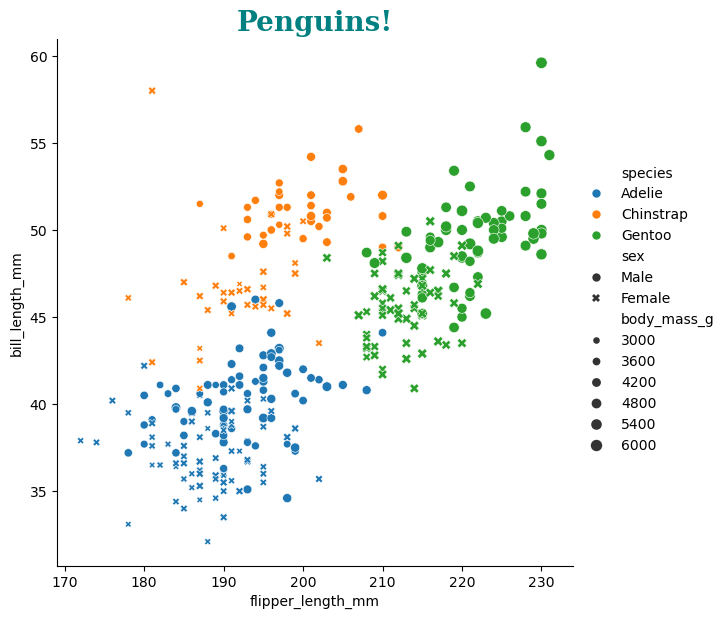

In [88]:
# Plot penguins with too much info
sns.relplot(data=penguins, x='flipper_length_mm', y='bill_length_mm',
            hue='species', style='sex', size='body_mass_g', height=6);
plt.title('Penguins!', fontdict={'color': 'teal', 'size': 20, 'weight': 'bold', 'family': 'serif'});

You may have noticed some pesky `NaN`s when we displayed the beginning of the DataFrame.\
We should investigate further.

<div class='exercise'> <b>Missingness</div>


In [89]:
# How many missing values in each column?
penguins.isna().sum()

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64

Let's take a look at them first all the rows with missing data.

In [90]:
# Rows with missingness
penguins[penguins.isna().any(axis=1)]

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
8,Adelie,Torgersen,34.1,18.1,193.0,3475.0,NaN
9,Adelie,Torgersen,42.0,20.2,190.0,4250.0,NaN
10,Adelie,Torgersen,37.8,17.1,186.0,3300.0,NaN
11,Adelie,Torgersen,37.8,17.3,180.0,3700.0,NaN
47,Adelie,Dream,37.5,18.9,179.0,2975.0,NaN
246,Gentoo,Biscoe,44.5,14.3,216.0,4100.0,NaN
286,Gentoo,Biscoe,46.2,14.4,214.0,4650.0,NaN
324,Gentoo,Biscoe,47.3,13.8,216.0,4725.0,NaN
336,Gentoo,Biscoe,44.5,15.7,217.0,4875.0,NaN


Yikes! There are two observations where all predictors except `species` and `island` are missing.\
These rows won't be of any use to us. We see that dropping rows missing `body_mass_g` will take care of most our missingness.

In [91]:
# Drop the bad rows identified above
penguins = penguins.dropna(subset=['body_mass_g'])
# Check state of missingness after dropping
penguins.isna().sum()

species              0
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
sex                  9
dtype: int64

It looks like there are 9 rows where `sex` is missing. We can try to **impute** these values.\
But first, take a look at our DataFrame again.

In [92]:
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male


Notice how the indices go from `2` to `4`. What happened to `3`?\
It was one of the rows we dropped! This issue with the indices can cause headaches later on (think `loc`/`iloc` distinction).
But we can make things good as new using the `reset_index` method. Just be sure to set `drop=True`, otherwise the old indices will be added to the DataFrame as a new column.

In [93]:
# Reset index
penguins = penguins.reset_index(drop=True)
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
4,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male


Much better!\
Now, on to imputing the missing `sex` values. Let's take a look at the `value_counts`.

In [94]:
# Counts of each unique value in the dataset
penguins.sex.value_counts()

sex
Male      168
Female    165
Name: count, dtype: int64

It's almost an even split. We'll impute the **mode** because it's a quick fix.

In [95]:
response = 'species'
X = penguins.drop(response, axis=1)
y = penguins[response]

In [96]:
# The mode here should match the value with the most counts above
sex_mode = penguins.sex.mode()[0]
sex_mode

'Male'

Finally, we use `fillna` to replace the remaining `NaN`s with the `sex_mode` and confirm that there are no more missing values in the DataFrame.

In [97]:
# Replace missing values with most common value (i.e, mode)
penguins = penguins.fillna(sex_mode)
penguins.isna().sum()

species              0
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

**Q:** Imputing the mode here was very easy, but does this approach make you a bit nervous? Why? Is there some other way we could have imputed this values?

<div class='exercise'> <b>Preprocessing</div>

We can't just throw this DataFrame at a neural network as it is. There's some work we need to do first.

**Separate predictors from response variable**

In [98]:
# Isolate response from predictors
response = 'species'
X = penguins.drop(response, axis=1)
y = penguins[response]

**Encode Categorical Predictor Variables**

In [99]:
# Check the predictor data types
X.dtypes

island                object
bill_length_mm       float64
bill_depth_mm        float64
flipper_length_mm    float64
body_mass_g          float64
sex                   object
dtype: object

Both `island` and `sex` are categotical. We can use `pd.get_dummies` to one-hot-encode them (don't forget to `drop_first`!).

In [100]:
# Identify the categorical columns
cat_cols = ['island', 'sex']

In [101]:
# one-hot encode the categorical columns
X_design = pd.get_dummies(X, columns=cat_cols, drop_first=True)
X_design.head(1)

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,island_Dream,island_Torgersen,sex_Male
0,39.1,18.7,181.0,3750.0,False,True,True


From the remaining columns we can infer that the 'reference' values for our categorical variables are `island = 'Biscoe'`, and `sex = 'Female'`.

**Feature Scaling**

We should take a closer look at the range of values our predictors take on.

In [102]:
#  Summary stats of predictors
X_design.describe()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,200.915205,4201.754386
std,5.459584,1.974793,14.061714,801.954536
min,32.100000,13.100000,172.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.000000,4750.000000
max,59.600000,21.500000,231.000000,6300.000000


Our features are not on the same scale. Just compare the min/max of `bill_depth_mm` and `body_mass_g` for example.\
This can slow down neural network training for reasons we'll see in an upcoming lecture.

Let's make use of `sklearn`'s `StandardScaler` to standardize the data, centering each predictor at 0 and setting their standard deviations to 1.

In [103]:
from sklearn.preprocessing import StandardScaler

In [104]:
# Remember the column names for later; we'll lose them when we scale
X_cols = X_design.columns
# Saving the scaler object in a variable allows us to reverse the transformation later
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_design)

In [105]:
# The scaler was passed a pandas DataFrame but returns a numpy array
type(X_scaled), X_scaled.shape

(numpy.ndarray, (342, 7))

In [106]:
# We can always add the column names back later if we need to
pd.DataFrame(X_scaled, columns=X_cols).head(3)

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,island_Dream,island_Torgersen,sex_Male
0,-0.884499,0.785449,-1.418347,-0.564142,-0.754193,2.388699,0.965507
1,-0.811126,0.126188,-1.062250,-0.501703,-0.754193,2.388699,-1.035725
2,-0.664380,0.430462,-0.421277,-1.188532,-0.754193,2.388699,-1.035725


**Encoding the Response Variable**

In [107]:
# Take a look at our response
y

0      Adelie
1      Adelie
2      Adelie
3      Adelie
4      Adelie
        ...  
337    Gentoo
338    Gentoo
339    Gentoo
340    Gentoo
341    Gentoo
Name: species, Length: 342, dtype: object

Our response variable is still a `string`. We need to turn it into some numerical representation for our neural network.\
We could to this ourselves with a few list comprehensions, but `sklearn`'s `LabelEncoder` makes this very easy.

In [108]:
from sklearn.preprocessing import LabelEncoder

In [109]:
# Encode string labels as integers
# LabelEncoder uses the familar fit/transform methods we saw with StandardScaler
labenc = LabelEncoder().fit(y)
y_enc = labenc.transform(y)
y_enc

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [110]:
# We can recover the class labels from the encoder object later
labenc.classes_

array(['Adelie', 'Chinstrap', 'Gentoo'], dtype=object)

This gets us part of the way there. But the penguin species are **categorical** not **ordinal**. Keeping the labels as integers implies that species `2` is twice as "different" from species `1` as it is from species `0`. We want to perform a conversion here similar to the one-hot encoding above, except will will not 'drop' one of the values. This is where Keras's `to_categorical` utility function comes in.

In [111]:
from keras.utils import to_categorical

In [112]:
y_cat = to_categorical(y_enc)
y_cat

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

Perfect!

**Q:** If this is what our array of response variables looks like, what will this mean for the output layer of our neural network?

**Train-test Split**

In [113]:
from sklearn.model_selection import train_test_split

You may be familiar with using `train_test_split` to split the `X` and `y` arrays themselves. But here we will using it to create a set of train and test *indices*.

We'll see later that being able to determine which rows in the original `X` and `y` ended up in train or test will be helpful.

**Q:** But couldn't we just sample integers to get random indices? Why use `train_test_split`?

**A:** Because `train_test_split` allows for **stratified** splitting!

Here we use a trick to stratify on both the `sex` and `island` variables by concatinating their values together. This gives us a total of 6 possible values (2 sexs x 3 islands). By stratifying on this column we help ensure that each of the 6 possible sex/island combinations is equally represented in both train and test.

In [114]:
# Concatenate categorical columns; use this for stratified splitting
strat_col = penguins['sex'].astype('str') + penguins['island'].astype('str')
strat_col

0        MaleTorgersen
1      FemaleTorgersen
2      FemaleTorgersen
3      FemaleTorgersen
4        MaleTorgersen
            ...       
337       FemaleBiscoe
338       FemaleBiscoe
339         MaleBiscoe
340       FemaleBiscoe
341         MaleBiscoe
Length: 342, dtype: object

In [115]:
# Create train/test indices
train_idx, test_idx = train_test_split(np.arange(X_scaled.shape[0]),
                                                  test_size=0.5,
                                                  random_state=109,
                                                  stratify=strat_col)

In [116]:
# Index into X_scaled and y_cat to create the train and test sets
X_train = X_scaled[train_idx]
y_train = y_cat[train_idx]
X_test = X_scaled[test_idx]
y_test = y_cat[test_idx]

In [117]:
# Sanity check on the resulting shapes
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((171, 7), (171, 3), (171, 7), (171, 3))

**Validation Split**

Here is where those indices we saved come in handy.\
We also want to also ensure equal representation across train and validation.

In [118]:
# Subset original stratify column using saved train split indices
strat_col2 = strat_col.iloc[train_idx]
strat_col2.shape

(171,)

In [119]:
# Create train and validation splits from original train split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                    test_size=0.5,
                                                    random_state=109,
                                                    stratify=strat_col2)

<div class="alert alert-success">
    <strong>🏋🏻‍♂️ TEAM ACTIVITY:</strong> Classify Those Penguins!</div>  

In [120]:
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.metrics import Accuracy, AUC
from tensorflow.keras.activations import softmax

**Build**

Construct your NN penguin classifier. You can make use of your `build_NN` function from earlier. What output activation should you use?

**Hint:** try to programaticlaly determin the input and output shape from your data rather than hard coding those values.

In [121]:
# Construct your NN and print the model summary
# your code here
model = models.Sequential(name='penguins')
model.add(layers.Dense(8, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(3, activation='relu'))
model.add(layers.Dense(y_train.shape[1], activation='softmax'))

model.summary()

Model: "penguins"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 8)                 64        
                                                                 
 dense_20 (Dense)            (None, 16)                144       
                                                                 
 dense_21 (Dense)            (None, 3)                 51        
                                                                 
 dense_22 (Dense)            (None, 3)                 12        
                                                                 
Total params: 271 (1.06 KB)
Trainable params: 271 (1.06 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**Compile**

Again, let's use `SGD` as our optimizer. You can fiddle with the `learning_rate`.\
What loss and metric(s) do you think are appropriate?

In [122]:
# Compile
# youre code here
model.compile(optimizer=optimizers.SGD(learning_rate=1e-1),
              loss='categorical_crossentropy',
              metrics=['acc', 'AUC'])

**Fit**

Fit your model and store the results in a variable called `history`.\
Feel free to play with `batch_size` and `epochs`.

Don't forget to include the `validation_data`!

In [123]:
# Fit
# your code here
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    batch_size=64,
                    epochs=50)

Epoch 1/50
2/2 [==============================] - 1s 239ms/step - loss: 1.1636 - acc: 0.3647 - auc: 0.4510 - val_loss: 1.0729 - val_acc: 0.5349 - val_auc: 0.6353
Epoch 2/50
2/2 [==============================] - 0s 24ms/step - loss: 1.0984 - acc: 0.4588 - auc: 0.5455 - val_loss: 1.0336 - val_acc: 0.5814 - val_auc: 0.7069
Epoch 3/50
2/2 [==============================] - 0s 28ms/step - loss: 1.0527 - acc: 0.4941 - auc: 0.6300 - val_loss: 0.9949 - val_acc: 0.6512 - val_auc: 0.7749
Epoch 4/50
2/2 [==============================] - 0s 28ms/step - loss: 1.0106 - acc: 0.5765 - auc: 0.7188 - val_loss: 0.9493 - val_acc: 0.6860 - val_auc: 0.8167
Epoch 5/50
2/2 [==============================] - 0s 30ms/step - loss: 0.9670 - acc: 0.6000 - auc: 0.7608 - val_loss: 0.9038 - val_acc: 0.7326 - val_auc: 0.8577
Epoch 6/50
2/2 [==============================] - 0s 30ms/step - loss: 0.9241 - acc: 0.6471 - auc: 0.7994 - val_loss: 0.8584 - val_acc: 0.7558 - val_auc: 0.8859
Epoch 7/50
2/2 [=================

**Plot**

Finally, write some code to visualize your loss and metric(s) across the training epochs. You should include both **train** and **validation** scores. This is where a **legend** is very important!

**Note:** If you load the solutions they may not run for you unless you have selected the same metric(s)

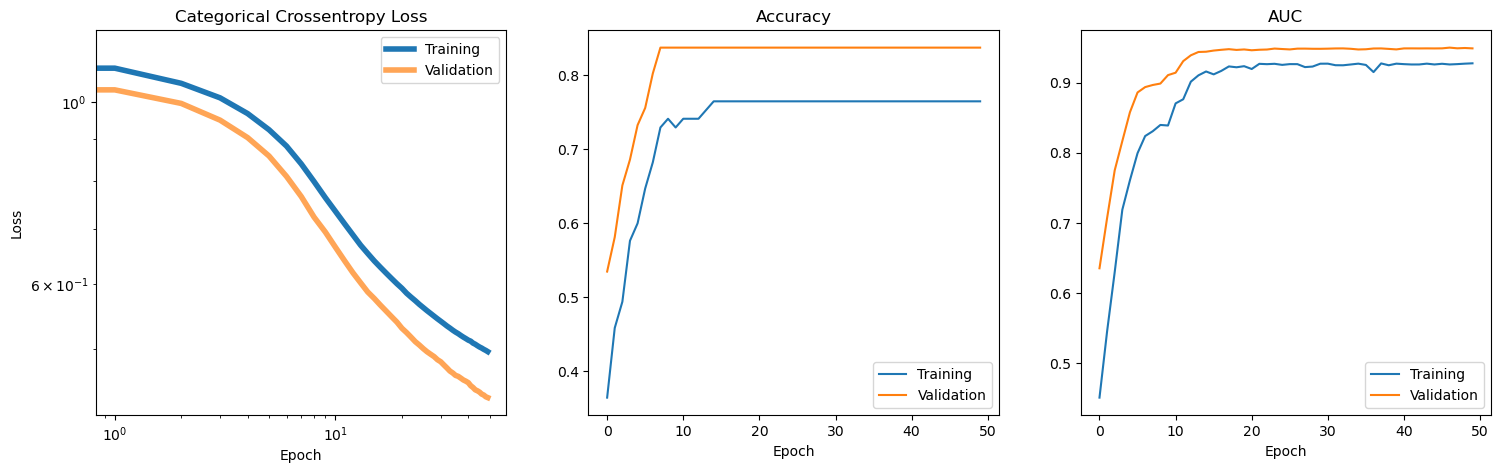

In [124]:
# Plot training history
# your code here
fig, axs = plt.subplots(1,3, figsize=(18,5))
                       
axs[0].loglog(history.history['loss'],linewidth=4, label = 'Training')
axs[0].loglog(history.history['val_loss'],linewidth=4, label = 'Validation', alpha=0.7)
axs[0].set_ylabel('Loss')


axs[1].plot(history.history['acc'], label='Training')
axs[1].plot(history.history['val_acc'], label='Validation')

axs[2].plot(history.history['auc'], label='Training')
axs[2].plot(history.history['val_auc'], label='Validation')

titles = ['Categorical Crossentropy Loss', 'Accuracy', 'AUC']
for ax, title in zip(axs, titles):
    ax.set_xlabel('Epoch')
    ax.set_title(title)
    ax.legend()

**End of Team Activity**

----

### Appendix

<div class='exercise'> <b>Evaluating the Model</div>


First, let's see how well we could to by simply predicting the majority class in the training data for all observations.

In [125]:
naive_acc = y_train.mean(axis=0).max()
print('Naive Accuracy:', naive_acc)

Naive Accuracy: 0.4


In [126]:
# Train
model.evaluate(X_train, y_train)

3/3 [==============================] - 0s 3ms/step - loss: 0.4944 - acc: 0.7647 - auc: 0.9270


[0.4943799674510956, 0.7647058963775635, 0.9269550442695618]

In [127]:
# Validation
model.evaluate(X_val, y_val)

3/3 [==============================] - 0s 3ms/step - loss: 0.4357 - acc: 0.8372 - auc: 0.9487


[0.43571561574935913, 0.8372092843055725, 0.9486885070800781]

In [128]:
# Test
model.evaluate(X_test, y_test)

6/6 [==============================] - 0s 2ms/step - loss: 0.4875 - acc: 0.8012 - auc: 0.9284


[0.48749426007270813, 0.8011695742607117, 0.9284052848815918]

<div class='exercise'> <b>Black Box Interpretation</div>


**Proxy Model**

In [129]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate, GridSearchCV

In [130]:
# Create train & test response variables for proxy model
y_train_bb = model.predict(X_train).argmax(-1)
y_test_bb = model.predict(X_test).argmax(-1)

6/6 [==============================] - 0s 856us/step


In [131]:
# Use cross-validation to tune proxy's hyperparameters
parameters = {'max_depth':range(1,10),
              'criterion': ['gini', 'entropy']}

clf = DecisionTreeClassifier(random_state=42)
grid = GridSearchCV(clf, parameters, cv=5)

# fit using same train but NN's predictions as response
grid.fit(X_train, y_train_bb)
print('Best Score:', grid.best_score_)
print('Best Params:', grid.best_params_) 

Best Score: 0.9647058823529411
Best Params: {'criterion': 'gini', 'max_depth': 2}


In [132]:
# Retrieve best estimator from the grid object
proxy = grid.best_estimator_

bb_test_score =  sum(y_test_bb == y_test.argmax(axis=1))/len(y_test_bb)
proxy_test_score = proxy.score(X_test, y_test_bb)
print('Black Box Test Score:', bb_test_score)
print('Proxy Model Test Score:', proxy_test_score)

Black Box Test Score: 0.8011695906432749
Proxy Model Test Score: 0.9649122807017544


**Feature Importance**

In [133]:
feature_importances = proxy.feature_importances_
feature_importances

array([0.        , 0.90207373, 0.        , 0.09792627, 0.        ,
       0.        , 0.        ])

In [134]:
sort_idx = np.argsort(feature_importances)[::-1]

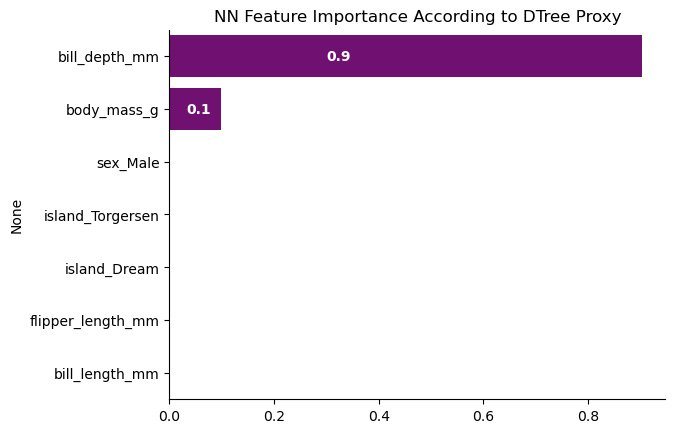

In [135]:
ax = sns.barplot(x=feature_importances[sort_idx], y=X_cols[sort_idx], color='purple', orient='h')
for index, val in enumerate(feature_importances[sort_idx]):
    ax.text(val/3, index, round(val, 2),color='white', weight='bold', va='center')
ax.set_title('NN Feature Importance According to DTree Proxy')
sns.despine(right=True)

**Fixing All But One Predictor**

We can also try to see how a predictor affects the NN's output by fixing all the other to some "reasonable" values (e.g., mean, mode) and then only varying the predictor of interest.

Based on the results above, let's explore how `bill_length_mm` effects the NN's output.

**Construct 'Average' Observation**

In [136]:
# Review data types
X_design.dtypes

bill_length_mm       float64
bill_depth_mm        float64
flipper_length_mm    float64
body_mass_g          float64
island_Dream            bool
island_Torgersen        bool
sex_Male                bool
dtype: object

In [137]:
# Take means for continous
means = X_scaled[:,:4].mean(axis=0)

# And modes for catgoricals
modes = pd.DataFrame(X_scaled[:,4:]).mode().values.reshape(-1)

In [138]:
# Shape Sanity Check
means.shape, modes.shape

((4,), (3,))

In [139]:
# Concatenate these two back together
avg_obs = np.concatenate([means, modes])

In [140]:
# And stick it back in a DataFrame
avg_obs = pd.DataFrame(avg_obs).transpose()
avg_obs.columns = X_design.columns
avg_obs

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,island_Dream,island_Torgersen,sex_Male
0,1.662088e-16,-1.412775e-15,-8.310441e-16,4.155221e-17,-0.754193,-0.418638,0.965507


In [141]:
# Identify column in our array that corresponds to bill length
bill_col = np.argmax(X_design.columns == 'bill_length_mm')

# Find the min and max bill length stdevs in the data set
bill_min_std = np.min(X_scaled[:,bill_col])
bill_max_std = np.max(X_scaled[:, bill_col])

# Create 100 evenly spaced values within that range
bill_lengths = np.linspace(bill_min_std, bill_max_std, 100)

# Create 100 duplicates of the average observation
avg_df  = pd.concat([avg_obs]*bill_lengths.size,ignore_index=True)

# Set the bill length column to then linspace we just created
avg_df['bill_length_mm'] = bill_lengths

Notice now that all rows are identical except for `bill_length_mm` which slowly covers the entire range of values observed in the dataset.

In [142]:
avg_df.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,island_Dream,island_Torgersen,sex_Male
0,-2.168526,-1.412775e-15,-8.310441e-16,4.155221e-17,-0.754193,-0.418638,0.965507
1,-2.117573,-1.412775e-15,-8.310441e-16,4.155221e-17,-0.754193,-0.418638,0.965507
2,-2.066619,-1.412775e-15,-8.310441e-16,4.155221e-17,-0.754193,-0.418638,0.965507
3,-2.015666,-1.412775e-15,-8.310441e-16,4.155221e-17,-0.754193,-0.418638,0.965507
4,-1.964712,-1.412775e-15,-8.310441e-16,4.155221e-17,-0.754193,-0.418638,0.965507


**Return Predictor to Original Scale**

When we visualize our results we'll want to do so back in the original scale for better interpretability.

Here we make use of our scaler object from way back when as it stores the means and standard deviations of the original, unscaled predictors.

In [143]:
# Recover the feature of interest on the original scale
bill_std = np.sqrt(scaler.var_[bill_col])
bill_mean = scaler.mean_[bill_col]
bill_lengths_original = (bill_std*bill_lengths)+bill_mean

We can sanity check out inverse transformation by confirming we recovereed the same min and max bill length from our very first DataFrame!

In [144]:
# Min Sanity Check
bill_lengths_original.min(), penguins.bill_length_mm.min()

(32.1, 32.1)

In [145]:
# Max Sanity Check
bill_lengths_original.max(), penguins.bill_length_mm.max()

(59.6, 59.6)

Now we are ready to plot an approximation of how `bill_length_mm` affects the NN's predictions.

4/4 [==============================] - 0s 2ms/step


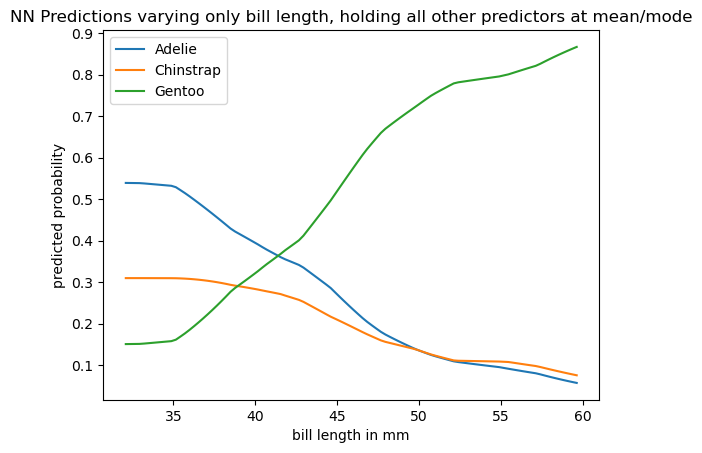

In [146]:
# Plot predicted class probabilities as a function of bill length (approx)
avg_pred = model.predict(avg_df)
fig, ax = plt.subplots()
for idx, species in enumerate(labenc.classes_): 
    plt.plot(bill_lengths_original, avg_pred[:,idx], label=species)
ax.set_ylabel('predicted probability')
ax.set_xlabel('bill length in mm')
ax.set_title('NN Predictions varying only bill length, holding all other predictors at mean/mode')

ax.legend();

If you know your penguins this should be too surprising. Gentoo penguins are the 3rd largest species after the emperor and king penguins (not represented in our dataset).

**Q:** Why is this only an *approximation* of how `bill_length_mm` from observations would affect the NN's predictions?

<div class='exercise'> <b>Bagging</div>

You'll be using bagging ("bootstrap aggregating") in your HW so let's take a minute to review the idea and see how it would work with a Kerass model.
    
The idea is to similuate multiple datasets by sampling our current one with replacement and fitting a model on this sample. The process is repeated multiple times until we have an *ensemble* of fitted models, all trained on slightly different datasets. 
    
We can then treat the ensemble as a singled 'bagged' model. When it is time to predict, each model in the ensemble makes its own predictions. These predictions can then be *aggregated* across models, for example, by taking the average or through majority voting.
    
We may also be interested in looking at the distribution of the predictions for a given observation as this may help us quanity our uncertainty in a way in which we could not with a single model's predictions (even if that model outputs a probability!)

**NN Build Function**\
**Arguments:**
- `name`: str - A name for your NN.
- `input_shape`: tuple - number of predictors in input (remember the trailing ','!)
- `hidden_dims`: list of int - specifies the number of neurons in each hidden layer
    - Ex: [2,4,8] would mean 3 hidden layers with 2, 4, and 8 neurons respectively
- `hidden_act`: str (or Keras activation object) - activation function used by all hidden layers
- `out_dim`: int - number of output neurons a.k.a 'ouput units'
- `out_act`: str (or Keras activation object) - activation function used by output layer

**Hint:** We will reuse this function throughout the notebook in different settings, but you should go ahead and set some sensible defaults for *all* of the arguments.

In [147]:
def build_NN(name='NN', input_shape=(1,), hidden_dims=[2], hidden_act='relu', out_dim=1, out_act='linear'):
    model = models.Sequential(name=name)
    model.add(layers.Input(shape=input_shape))
    for hidden_dim in hidden_dims:
        model.add(layers.Dense(hidden_dim, activation=hidden_act))
    model.add(layers.Dense(out_dim, activation=out_act))
    return model

In [148]:
# Set sup parameters for the bagging process
learning_rate=1e-1
epochs = 50
batch_size = 64
n_boot = 30
bagged_model = []
np.random.seed(109)

for n in range(n_boot):
    # Bootstrap
    boot_idx = np.random.choice(X_train.shape[0], size=X_train.shape[0], replace=True)
    X_train_boot = X_train[boot_idx]
    y_train_boot = y_train[boot_idx]

    # Build
    boot_model= build_NN(name=f'penguins_{n}',
                        input_shape=(X_train_boot.shape[1],),
                        hidden_dims=[8,16,32],
                        hidden_act='relu',
                        out_dim=3,
                        out_act='softmax')
    # Compile
    boot_model.compile(optimizer=optimizers.SGD(learning_rate=learning_rate),
                       loss='categorical_crossentropy',
                       metrics=['acc', 'AUC'])

    # Fit
    boot_model.fit(X_train_boot,
                   y_train_boot,
                   batch_size=batch_size,
                   epochs=epochs,
                   verbose=0)
    
    # Store bootstrapped model's probability predictions
    bagged_model.append(boot_model)

In [149]:
# Notice we can programatically recover the shape of a model's output layer
m = bagged_model[0]
out_dim = m.layers[-1].output_shape[-1]
print(out_dim)

3


In [150]:
def get_bagged_pred(bagged_model, X): 
    # Number of observations
    n_obs = X.shape[0]
    # Prediction dimensions (here, number of classes)
    pred_dim = bagged_model[0].layers[-1].output_shape[-1]
    # Number of models in the bagged ensemble
    n_models = len(bagged_model)
    # 3D tensor to store predictions from each bootstrapped model
    # n_observations x n_classes x n_models
    boot_preds = np.zeros((n_obs, pred_dim, n_models))
    # Store all predictions in the tensor
    for i, model in enumerate(bagged_model):
        boot_preds[:,:,i] = model.predict(X)
    # Average the predictions across models
    bag_pred = boot_preds.mean(axis=-1)
    return bag_pred, boot_preds

In [151]:
# Get aggregated and unaggregated ensemble predictions
bag_pred, boot_preds = get_bagged_pred(bagged_model, X_test)

6/6 [==============================] - 0s 1ms/step


In [152]:
# Example of aggregated predictions
bag_pred[:3]

array([[0.03264397, 0.94588308, 0.02147297],
       [0.04209376, 0.9383751 , 0.01953115],
       [0.04834233, 0.92980878, 0.0218489 ]])

In [153]:
# Shape of unaggregated ensemble predictions tensor
boot_preds.shape

(171, 3, 30)

In [154]:
# Calculate bagged accuracy
bag_acc = sum(bag_pred.argmax(axis=-1) == y_test.argmax(axis=-1))/bag_pred.shape[0]
print('Bagged Acc:', bag_acc)

Bagged Acc: 0.9941520467836257


**The End** 🌈